## 14.1 텐서플로의 주요 특징

## 14.2 텐서플로의 계산 그래프: 텐서플로 v2로 이전

* 즉시 실행, 동적 계산 그래프

### 14.2.6 함수 데코레이터로 계산 성능 높이기

`@tf.function`: 정적 타입과 크기가 필요하지만 이를 동적 타이핑으로 처리할 수 있음

## 14.3 모델 파라미터를 저장하고 업데이트하기 위한 텐서플로 변수 객체

In [1]:
# 랜덤 초기화의 일종 고전적인 랜덤 초기화 방법: 글로럿 초기화 (GlorotNormal)

import tensorflow as tf

tf.random.set_seed(1)
init = tf.keras.initializers.GlorotNormal()
tf.print(init(shape=(3, )))

[-0.722795904 1.01456821 0.251808226]


2022-04-25 17:51:51.410816: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
v = tf.Variable(init(shape=(2, 3)))
tf.print(v)

[[0.28982234 -0.782292783 -0.0453658961]
 [0.960991383 -0.120003454 0.708528221]]


In [3]:
class MyModule(tf.Module):
    def __init__(self):
        init = tf.keras.initializers.GlorotNormal()
        self.w1 = tf.Variable(init(shape=(2, 3)),
                              trainable=True)
        self.w2 = tf.Variable(init(shape=(1, 2)),
                              trainable=False)

m = MyModule()
print('모든 변수: ', [v.shape for v in m.variables])
print('훈련 가능한 변수: ', [v.shape for v in m.trainable_variables])

모든 변수:  [TensorShape([2, 3]), TensorShape([1, 2])]
훈련 가능한 변수:  [TensorShape([2, 3])]


2022-04-25 17:51:51.657435: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


In [4]:
# 함수 밖에서 Variable 객체를 정의하고 데코레이터 사용
w = tf.Variable(tf.random.uniform((3, 3)))

@tf.function
def compute_z(x):
    return tf.matmul(w, x)

x = tf.constant([[1], [2], [3]], dtype=tf.float32)
tf.print(compute_z(x))

[[1.20935762]
 [3.89828062]
 [1.65398622]]


2022-04-25 17:51:51.788365: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)


## 14.4 자동 미분과 GradientTape로 그레디언트 계산

### 14.4.1 훈련 가능한 변수에 대한 손실의 그레디언트 계산

$z\,=\,wx\,+\,b$을 자동 미분하여 제곱 오차 - loss를 구하고 이를 $w$에 대해 편미분해서 그레디언트 구하기

In [5]:
w = tf.Variable(1.0)
b = tf.Variable(0.5)
print(w.trainable, b.trainable)

True True


In [6]:
x = tf.convert_to_tensor([1.4])
y = tf.convert_to_tensor([2.1])
with tf.GradientTape() as tape:
    z = tf.add(tf.multiply(w, x), b)
    loss = tf.reduce_sum(tf.square(y - z))
dloss_dw = tape.gradient(loss, w)
tf.print('dL/dw: ', dloss_dw)

dL/dw:  -0.559999764


### 14.4.2 훈련하지 않는 변수에 대한 그레디언트 계산
`tf.watch()`: 적대 샘플을 생성하는 데 사용

### 14.4.3 여러 개의 그레디언트 계산

`tf.GradientTape(persistent=True)`

In [7]:
with tf.GradientTape(persistent=True) as tape:
    z = tf.add(tf.multiply(w, x), b)
    loss = tf.reduce_sum(tf.square(y - z))
dloss_dw = tape.gradient(loss, w)
tf.print('dL/dw: ', dloss_dw)

dloss_db = tape.gradient(loss, b)
tf.print('dL/db: ', dloss_db)

dL/dw:  -0.559999764
dL/db:  -0.399999857


In [8]:
# keras API 이용하여 구하기
optimizer = tf.keras.optimizers.SGD()
optimizer.apply_gradients(zip([dloss_dw, dloss_db], [w, b]))
tf.print('업데이트 된 w: ', w)
tf.print('업데이트 된 b: ', b)

업데이트 된 w:  1.0056
업데이트 된 b:  0.504


## 14.5 케라스 API를 사용하여 일반적인 구조 구현하기

In [9]:
# 복습
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(units=16, activation='relu'))
model.add(tf.keras.layers.Dense(units=32, activation='relu'))

model.build(input_shape=(None, 4))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                80        
_________________________________________________________________
dense_1 (Dense)              (None, 32)                544       
Total params: 624
Trainable params: 624
Non-trainable params: 0
_________________________________________________________________


In [10]:
# 훈련하는 / 훈련하지 않는 파라미터 출력하기
for v in model.variables:
    print('{:20s}'.format(v.name), v.trainable, v.shape)

dense/kernel:0       True (4, 16)
dense/bias:0         True (16,)
dense_1/kernel:0     True (16, 32)
dense_1/bias:0       True (32,)


* 공식 문서 링크

* 각 layer에 적용 가능

`tf.keras.activations`: http://www.tensorflow.org/api_docs/python/tf/keras/activations  
`tf.keras.initializers`: http://www.tensorflow.org/api_docs/python/tf/keras/initializers  
`tf.keras.regularizers`: http://www.tensorflow.org/api_docs/python/tf/keras/regularizers  

* compile할 때 모델의 설정 바꾸기

`tf.keras.optimizers`: http://www.tensorflow.org/api_docs/python/tf/keras/optimizers  
`tf.keras.losses`: http://www.tensorflow.org/api_docs/python/tf/keras/losses  
`tf.kera.metrics`: http://www.tensorflow.org/api_docs/python/tf/keras/metrics

### 14.5.1 XOR 분류 문제 풀어 보기

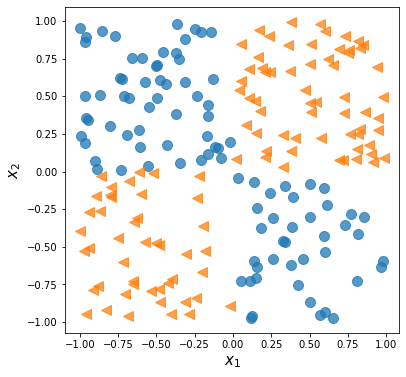

In [11]:
import numpy as np
import matplotlib.pyplot as plt

tf.random.set_seed(1)
np.random.seed(1)

x = np.random.uniform(low=-1, high=1, size=(200, 2))
y = np.ones(len(x))
y[x[:, 0] * x[:, 1] < 0] = 0

x_train = x[:100, :]
y_train = y[:100]

x_valid = x[100:, :]
y_valid = y[100:]

fig = plt.figure(figsize=(6, 6))
plt.plot(x[y==0, 0],
         x[y==0, 1], 'o', alpha=0.75, markersize=10)
plt.plot(x[y==1, 0],
         x[y==1, 1], '<', alpha=0.75, markersize=10)
plt.xlabel(r'$x_1$', size=15)
plt.ylabel(r'$x_2$', size=15)
plt.show()

In [12]:
# 간단한 기본 모델로 시작
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(units=1,
                                input_shape=(2, ),
                                activation='sigmoid'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 1)                 3         
Total params: 3
Trainable params: 3
Non-trainable params: 0
_________________________________________________________________


In [13]:
# 컴파일 그리고 적합
model.compile(optimizer=tf.keras.optimizers.SGD(),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy()])
hist = model.fit(x_train, y_train,
                 validation_data=(x_valid, y_valid),
                 epochs=200, batch_size=2, verbose=0)

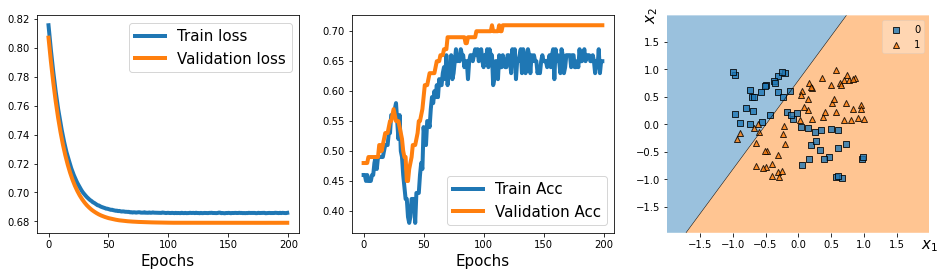

In [14]:
# 결정 영역과 훈련 성능을 그리기
from mlxtend.plotting import plot_decision_regions
history = hist.history
fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 3, 1)
plt.plot(history['loss'], lw=4)
plt.plot(history['val_loss'], lw=4)
plt.legend(['Train loss', 'Validation loss'], fontsize=15)
ax.set_xlabel('Epochs', size=15)

ax = fig.add_subplot(1, 3, 2)
plt.plot(history['binary_accuracy'], lw=4)
plt.plot(history['val_binary_accuracy'], lw=4)
plt.legend(['Train Acc', 'Validation Acc'], fontsize=15)
ax.set_xlabel('Epochs', size=15)

ax = fig.add_subplot(1, 3, 3)
plot_decision_regions(X=x_valid, y=y_valid.astype(np.int64), clf=model)
ax.set_xlabel(r'$x_1$', size=15)
ax.xaxis.set_label_coords(1, -0.025)
ax.set_ylabel(r'$x_2$', size=15)
ax.yaxis.set_label_coords(-0.025, 1)
plt.show()

# 은닉층이 없는 단순한 모델은 선형 결정 경계만 찾게 되어 결과가 좋지 않다.

In [15]:
# 은닉층을 1~4개까지 더해보기
tf.random.set_seed(1)
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(units=4, input_shape=(2, ),
                                activation='relu'))
model.add(tf.keras.layers.Dense(units=4, activation='relu'))
model.add(tf.keras.layers.Dense(units=4, activation='relu'))
model.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 4)                 12        
_________________________________________________________________
dense_4 (Dense)              (None, 4)                 20        
_________________________________________________________________
dense_5 (Dense)              (None, 4)                 20        
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 5         
Total params: 57
Trainable params: 57
Non-trainable params: 0
_________________________________________________________________


In [16]:
# 컴파일
model.compile(optimizer=tf.keras.optimizers.SGD(),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy()])

# 훈련
hist = model.fit(x_train, y_train,
                 validation_data=(x_valid, y_valid),
                 epochs=200, batch_size=2, verbose=0)

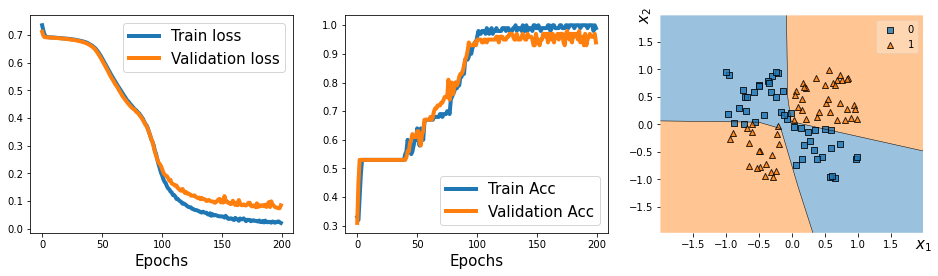

In [17]:
# 그림 그리기 (이전 코드 재사용)
history = hist.history
fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 3, 1)
plt.plot(history['loss'], lw=4)
plt.plot(history['val_loss'], lw=4)
plt.legend(['Train loss', 'Validation loss'], fontsize=15)
ax.set_xlabel('Epochs', size=15)

ax = fig.add_subplot(1, 3, 2)
plt.plot(history['binary_accuracy'], lw=4)
plt.plot(history['val_binary_accuracy'], lw=4)
plt.legend(['Train Acc', 'Validation Acc'], fontsize=15)
ax.set_xlabel('Epochs', size=15)

ax = fig.add_subplot(1, 3, 3)
plot_decision_regions(X=x_valid, y=y_valid.astype(np.int64), clf=model)
ax.set_xlabel(r'$x_1$', size=15)
ax.xaxis.set_label_coords(1, -0.025)
ax.set_ylabel(r'$x_2$', size=15)
ax.yaxis.set_label_coords(-0.025, 1)
plt.show()

### 14.5.3 케라스의 Model 클래스 기반으로 모델 만들기

In [18]:
# tf.keras.Model 상속한 새로운 클래스 생성
class MyModel(tf.keras.Model):
    def __init__(self):
        super(MyModel, self).__init__()
        self.hidden_1 = tf.keras.layers.Dense(
            units=4, activation='relu')
        self.hidden_2 = tf.keras.layers.Dense(
            units=4, activation='relu')
        self.hidden_3 = tf.keras.layers.Dense(
            units=4, activation='relu')
        self.output_layer = tf.keras.layers.Dense(
            units=1, activation='sigmoid')
        
    def call(self, inputs):
        h = self.hidden_1(inputs)
        h = self.hidden_2(h)
        h = self.hidden_3(h)
        return self.output_layer(h)

In [19]:
tf.random.set_seed(1)
model = MyModel()  # 일반적인 모델 속성을 상속
model.build(input_shape=(None, 2))
model.summary()

# Compile
model.compile(optimizer=tf.keras.optimizers.SGD(),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy()])

# Training
hist = model.fit(x_train, y_train,
                 validation_data=(x_valid, y_valid),
                 epochs=200, batch_size=2, verbose=0)

Model: "my_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              multiple                  12        
_________________________________________________________________
dense_8 (Dense)              multiple                  20        
_________________________________________________________________
dense_9 (Dense)              multiple                  20        
_________________________________________________________________
dense_10 (Dense)             multiple                  5         
Total params: 57
Trainable params: 57
Non-trainable params: 0
_________________________________________________________________


In [20]:
# train_step() method에서 tf.GradientTape 컨텍스트로 훈련 단계를 세밀하게 조정할 수 있다.
class MyCustomStepModel (MyModel):
    
    def train_step(self, data):
        # fit()에 전달된 데이터
        x, y = data
        
        # gradient 기록 시작
        with tf.GradientTape() as tape:
            # 정방향 계산
            y_pred = self(x)
            # compile() method에서 지정한 손실 계산
            loss = self.compiled_loss(y, y_pred, regularization_losses=self.losses)
            
        # 훈련 가능한 파라미터에 대한 그레디언트 계산
        gradients = tape.gradient(loss, self.trainable_variables)
        # 파라미터 업데이트
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        
        # TF 2.4에서
        # self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
        
        # compile() 메서드에서 지정한 지표 계산
        self.compiled_metrics.update_state(y, y_pred)
        
        # 현재까지 지표와 결과값을 딕셔너리로 반환
        return {m.name: m.result() for m in self.metrics}